In [53]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/analytic.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")


In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import thinkplot
import thinkstats2
import scipy
import statsmodels.formula.api as smf
import brfss
import random
import analytic
import math
import locale
import hypothesis
from prettytable import PrettyTable
import textblob
from spellchecker import SpellChecker

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

I currently work for a holding company with many subsidiaries. My functions include finance manager,
data warehousing and management as well as risk analysis and claims reserve projections on ultimate loss
ratios. Claims are the leading expense on an insuring business’s profit statement outside of reinsurance and salaries. Much emphasis is placed on predicting how a product will perform. This leads to evaluating the
reasonableness of the warranty cost and claims experience to present loss reserves. The subsidiary I will
focus on for this project is a warranty group that specializes in servicing extended warranties on appliances
(refrigerators, washers, dryers, stoves, small home appliances), TV’s and other electronics (audio equipment,
home wine coolers, portable air conditioners, mobile phones). These products can have different warranty
periods from 12 months to 5 years. The reason I am choosing this subsidiary is due to the fact that their
operating income has fallen in the past couple of years. Assumption is that this is due to an increase in
claims experience since bringing on a large client. This particular buying group (many dealers under the
same contract) product mix consists 99% of refrigerators, washers, TV’s and small home appliances.

The data set below contains all sales and claim information for the last 3 years for the buying group. Including contract number, product sold, manufacturer, dealer name, warranty terms, sale date, warranty costs and retail costs.

In [55]:
df = pd.read_excel(r'Sales_Original2.xlsx')
df.head(10) 

,ContractNumber,DealerNumber,DealerName,ProductDescription,ManufacturerDescription,ModelNumber,StateCode,ReceivedDate,EffectiveDate,PurchaseDate,...,ContractTerm,ContractType,WarrantyType,ServiceType,ContractCostAmount,ProductRetailAmount,ClaimAmount,Loss Date,ProductGroup,PWCProductGroup
0,AU48094,56596 A,BON MARCHE APPLIANCE CENTER,MICROWAVE,FRIGIDAIRE,FGMV17WNVF,LA,2021-09-30,2022-09-19,2021-09-18,...,3,Replace,Repl.,In Shop,23.15,298.00,0.0,NaN,Appliance,All Other Appliance
1,AU48115,56596 A,BON MARCHE APPLIANCE CENTER,MICROWAVE,FRIGIDAIRE,FFMV1845VS,LA,2021-09-30,2022-09-18,2021-09-17,...,3,Replace,Repl.,In Shop,23.15,248.00,0.0,NaN,Appliance,All Other Appliance
2,AU49973,57054 A,BOBCAT HOME FURNISHINGS CO,FREEZER,GALANZ,GLF70CWED0,MT,2021-09-30,2022-09-18,2021-09-17,...,3,Replace,Repl.,In Shop,20.15,289.99,0.0,NaN,Appliance,All Other Appliance
3,AU48097,56596 A,BON MARCHE APPLIANCE CENTER,FREEZER,ASCOLI,ACCF0700W1,LA,2021-09-30,2022-08-27,2021-08-26,...,2,Replace,Repl.,In Shop,14.01,218.00,0.0,NaN,Appliance,All Other Appliance
4,AU47695,56181 A,LYONS APPLIANCE,FREEZER,FRIGIDAIRE,FFCS0722AW,IA,2021-09-30,2021-09-30,2021-09-30,...,5,Repair,Serv.,On Site,64.72,349.00,0.0,NaN,Appliance,All Other Appliance
5,AU47946,56464 A,RW MCDONALD AND SONS,REFRIGERATOR,GE,GNE25JMKES,PA,2021-09-30,2021-09-30,2021-09-30,...,5,Repair,Serv.,On Site,114.33,1800.00,0.0,NaN,Appliance - Refrig,Appliance
6,AU48170,56694 A,CHAVIS FURNITURE,REFRIGERATOR,GE,GNE27JYMFS,AL,2021-09-30,2021-09-30,2021-09-30,...,5,Repair,Serv.,On Site,114.33,1959.00,0.0,NaN,Appliance - Refrig,Appliance
7,AU48171,56694 A,CHAVIS FURNITURE,RANGE,SAMSUNG,NX58T7511S,AL,2021-09-30,2021-09-30,2021-09-30,...,5,Repair,Serv.,On Site,59.28,829.00,0.0,NaN,Appliance,All Other Appliance
8,AU47753,56204 A,NIX HOME CENTER,REFRIGERATOR,GE,GSS25GMHES,AR,2021-09-30,2021-09-30,2021-09-30,...,5,Repair,Serv.,On Site,114.33,1599.00,0.0,NaN,Appliance - Refrig,Appliance
9,AU48169,56694 A,CHAVIS FURNITURE,REFRIGERATOR,WHIRLPOOL,WRS321SDHW,AL,2021-09-30,2021-09-30,2021-09-30,...,5,Repair,Serv.,On Site,97.32,1399.00,0.0,NaN,Appliance - Refrig,Appliance


__Choose a minimum of 5 variables in your dataset used during your analysis.__

The vairables I am focusing within my dataset are:
1. Contract Number = Value assigned at purchase of extended warranty for policy identification.
2. Product Description = Description of item purchased that the warranty was placed for.
3. Manufacturer Description = Manufacturer of product sold. 
4. State Code = State the product was purchased in.
5. Contract Cost Amount = Purchase price of warranty placed on product.
6. Claim Amount = If a claim was made on the product, the cost of the claim total. 
7. Dealer Name = Store the product was purchased in. 
8. Product Retail Amount = Cost of the product at time of purchase. 

In [56]:
df_variables = df[['ContractNumber', 'ProductDescription', 'ManufacturerDescription', 'StateCode',\
                   'ContractCostAmount', 'ClaimAmount', 'DealerName', 'ProductRetailAmount']]

In [98]:

df_variables.head()

,ContractNumber,ProductDescription,ManufacturerDescription,StateCode,ContractCostAmount,ClaimAmount,DealerName,ProductRetailAmount
0,AU48094,MICROWAVE,FRIGIDAIRE,LA,23.15,0.0,BON MARCHE APPLIANCE CENTER,298.00
1,AU48115,MICROWAVE,FRIGIDAIRE,LA,23.15,0.0,BON MARCHE APPLIANCE CENTER,248.00
2,AU49973,FREEZER,GALANZ,MT,20.15,0.0,BOBCAT HOME FURNISHINGS CO,289.99
3,AU48097,FREEZER,ASCOLI,LA,14.01,0.0,BON MARCHE APPLIANCE CENTER,218.00
4,AU47695,FREEZER,FRIGIDAIRE,IA,64.72,0.0,LYONS APPLIANCE,349.00


In [58]:
df_variables.describe()

,ContractCostAmount,ClaimAmount,ProductRetailAmount
count,561962.000000,561962.000000,561962.000000
mean,75.458236,10.762085,1279.801189
std,33.728644,57.943497,1091.018191
min,3.840000,0.000000,0.000000
25%,57.040000,0.000000,679.000000
50%,69.630000,0.000000,909.000000
75%,92.210000,0.000000,1519.990000
max,703.410000,10068.810000,18999.000000


In [59]:
df2 = pd.DataFrame(df_variables.groupby(['ProductDescription'])['ProductDescription'].count())
df2 = df2.rename(columns={'ProductDescription' : 'Count'})
df2 = df2.sort_values(by=['Count'], ascending=False)
df2


,Count
ProductDescription,
REFRIGERATOR,136141
WASHER,103095
DISHWASHER,83966
DRYER,73021
RANGE,68216
FREEZER,19790
REFRIGERATOR-W/ICE,16831
MICROWAVE,16520
WALL OVEN,11173


__Include a histogram of each of the variables - in your summary and analysis, identify any outliers and explain the reasoning for them being outliers and how you believe they should be handled.__

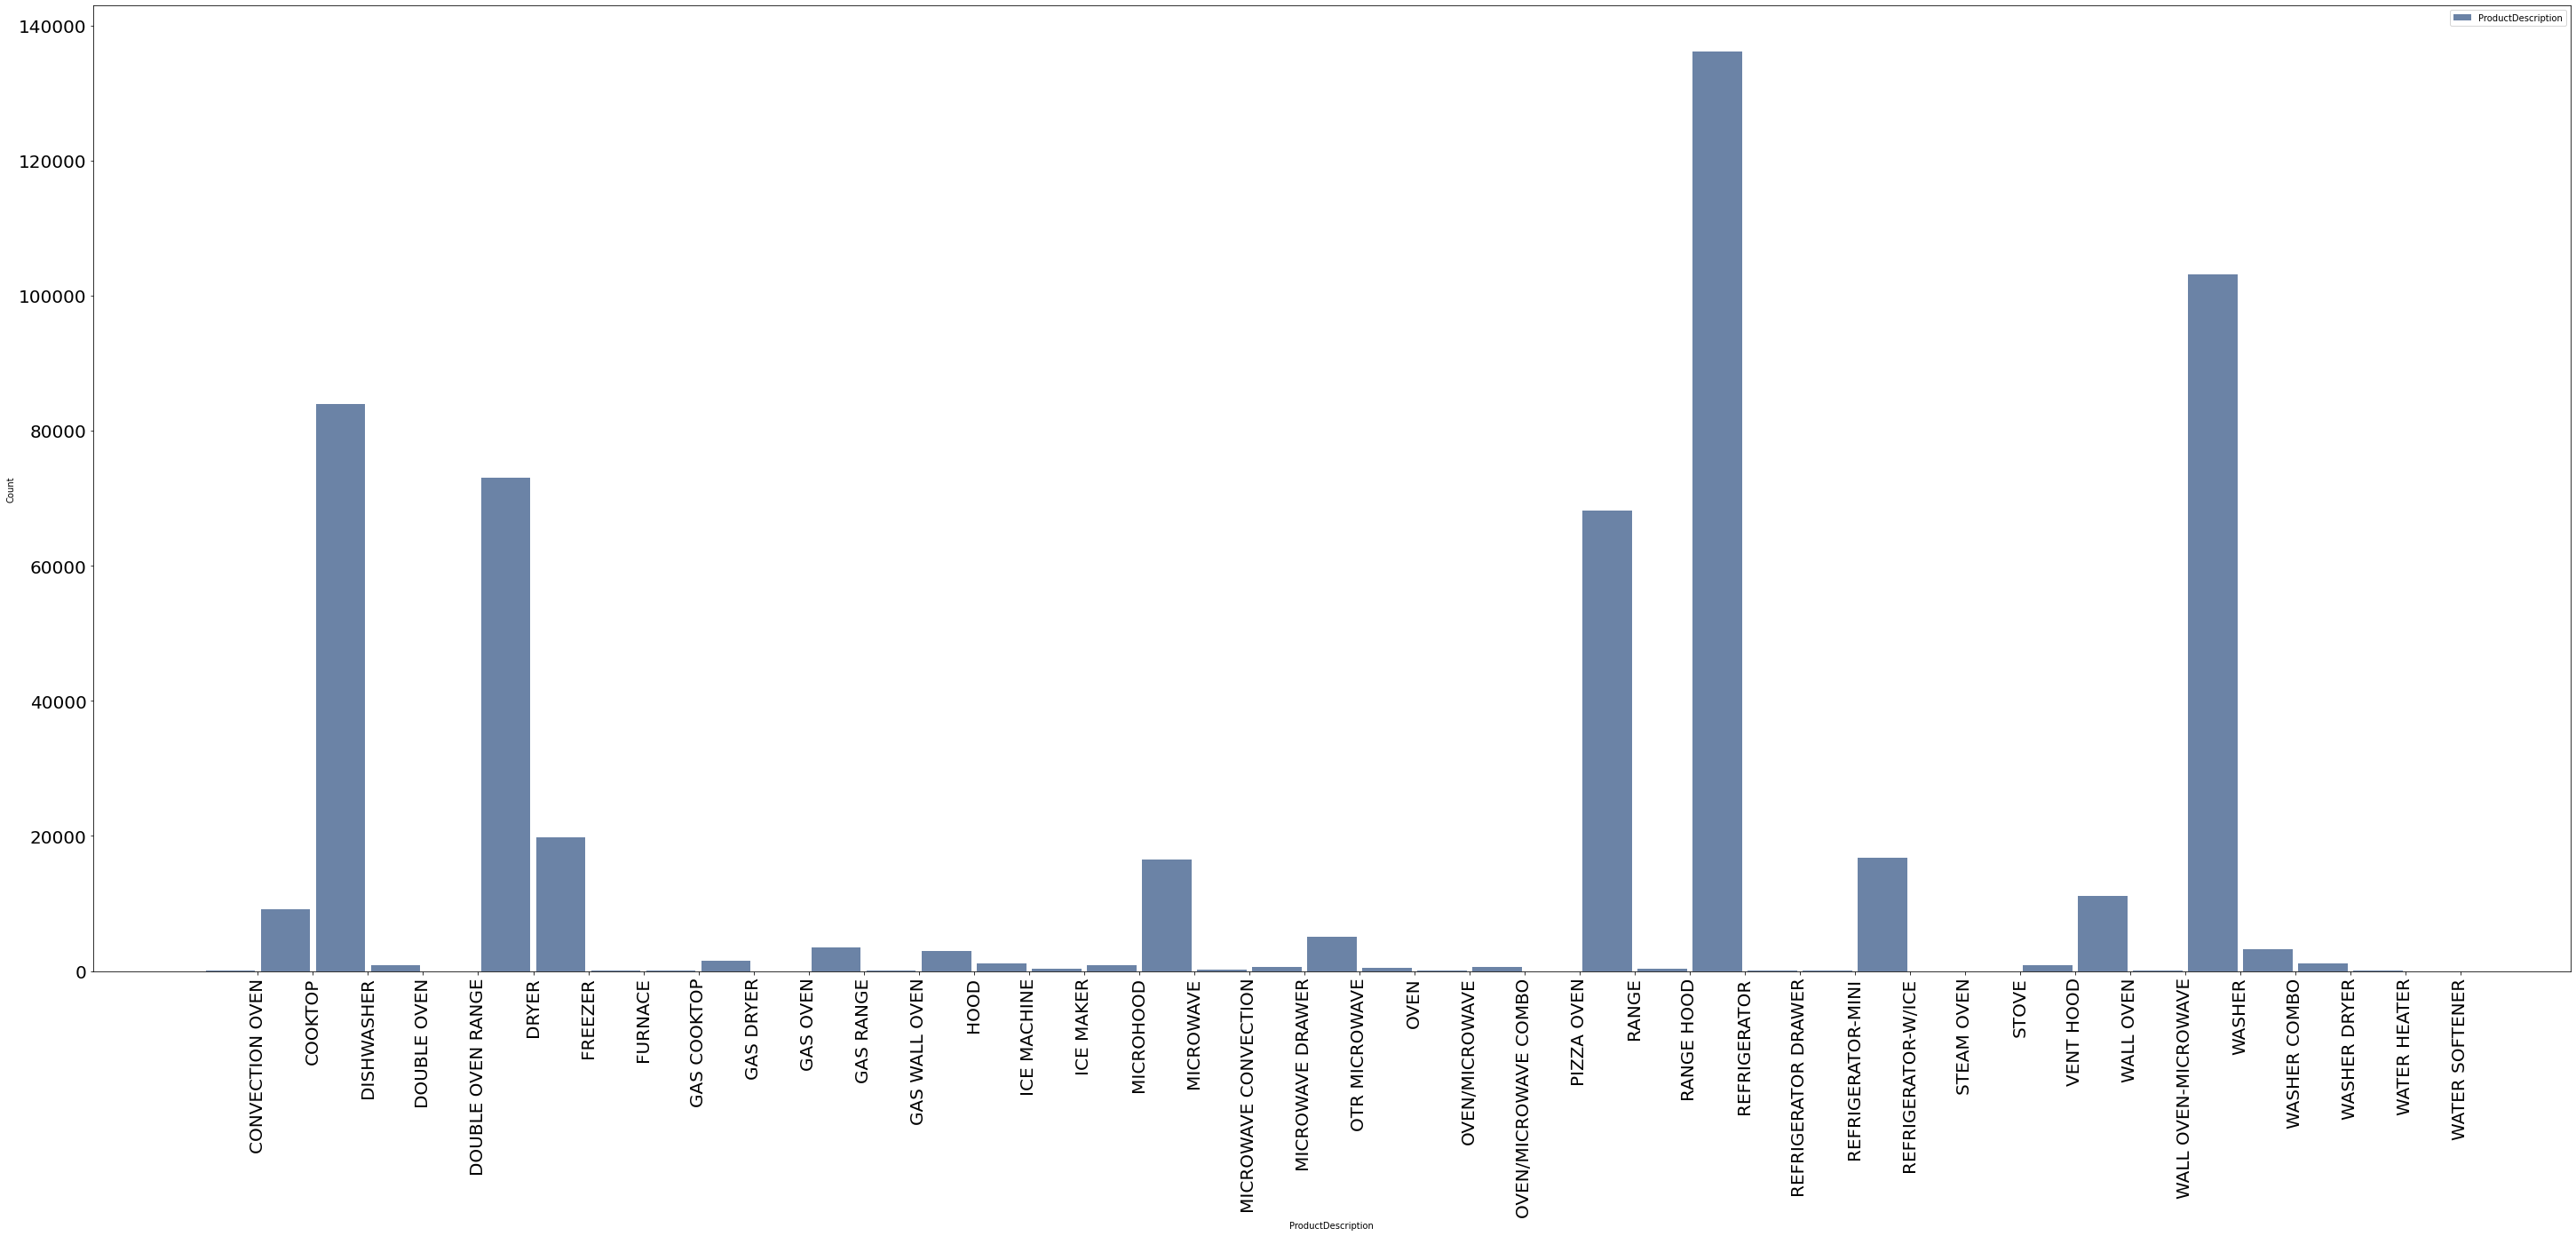

In [60]:
plt.figure(figsize=(50,20))
histogram_product = thinkstats2.Hist(df_variables['ProductDescription'], label='ProductDescription')
thinkplot.Hist(histogram_product, align='center')
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
thinkplot.Config(xlabel='ProductDescription', ylabel='Count')

The histogram shows that the most sold warranties belong to the product groups; refridgerators, washers, dishwashers, dryers and ranges. The outliers could be the least sold product warranties such as water softeners and pizza ovens, making them insignificant to the study. 

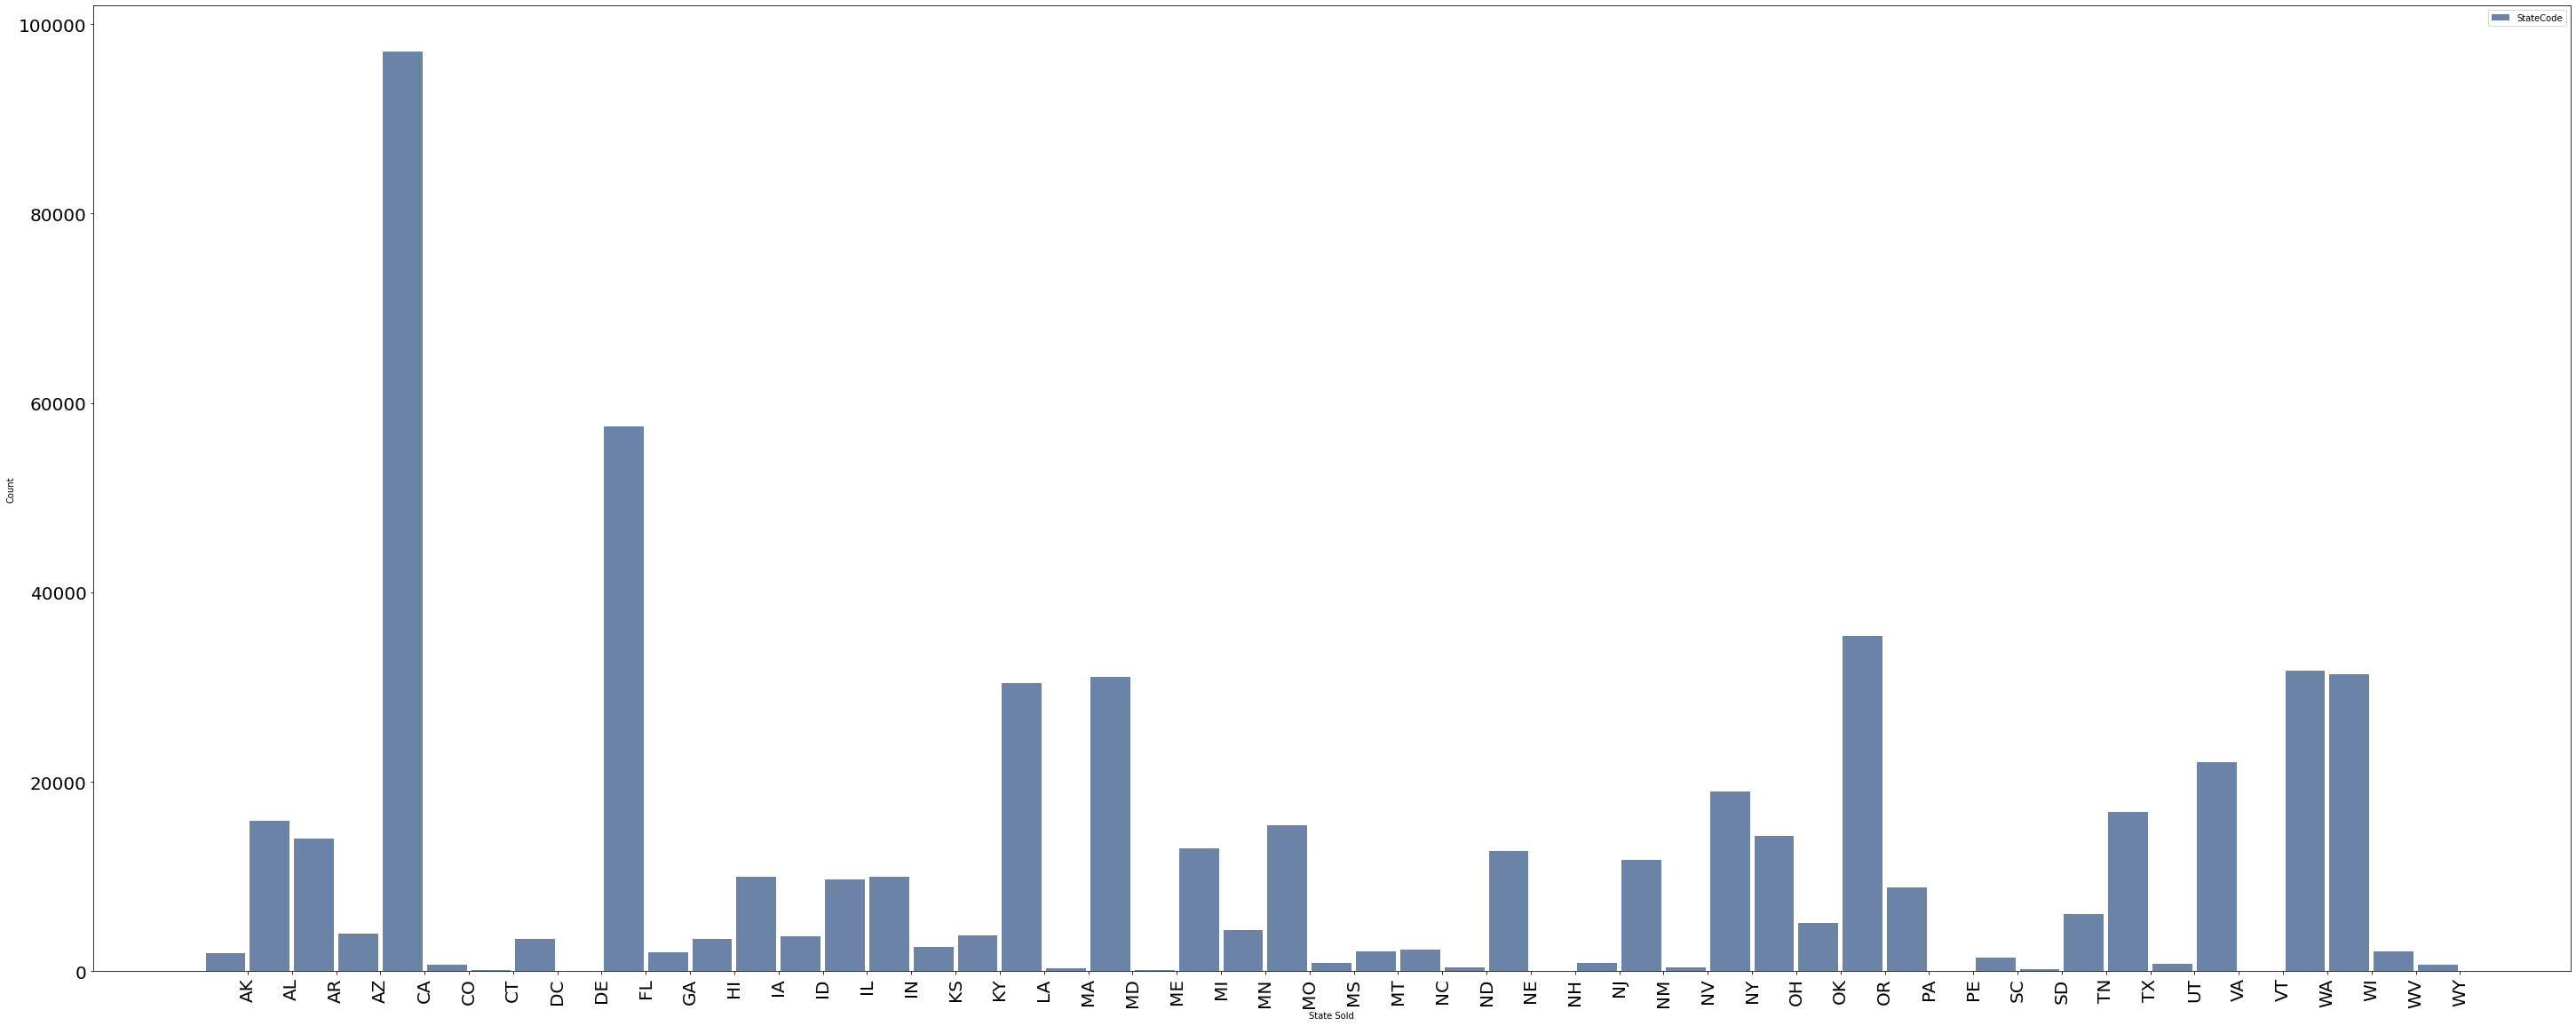

In [61]:
plt.figure(figsize=(50,20))
histogram_product = thinkstats2.Hist(df_variables['StateCode'], label='StateCode')
thinkplot.Hist(histogram_product, align='center')
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
thinkplot.Config(xlabel='State Sold', ylabel='Count')

The state histogram shows the concentration of products are being sold in California and Florida.  Again outliers are states with little to no sales.  Would be insignificant to study and excluded if needed.  

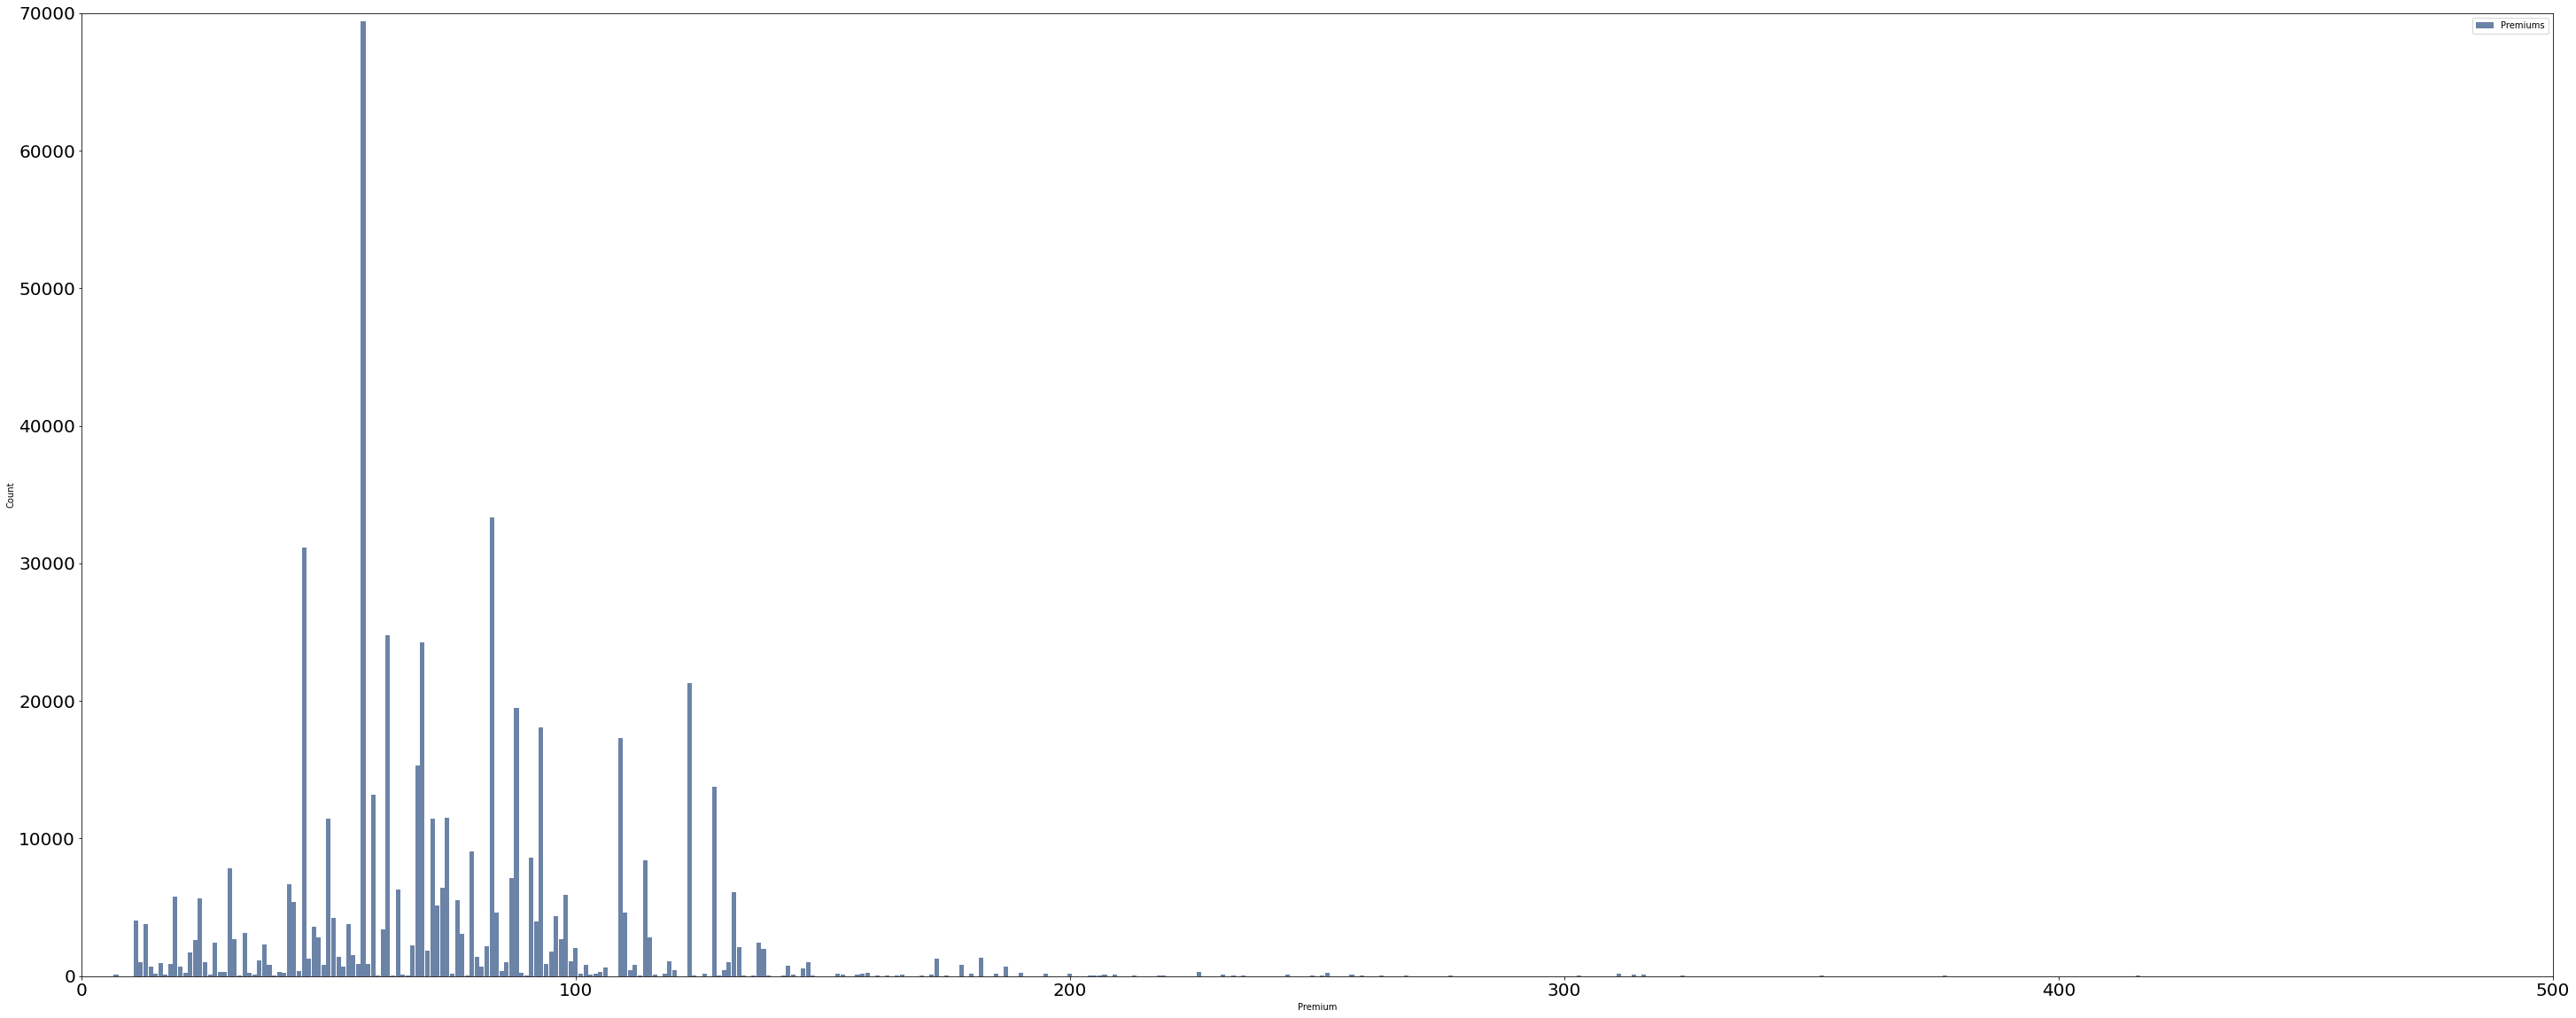

In [62]:
plt.figure(figsize=(50,20))
flr_cost = np.floor(df_variables['ContractCostAmount'])
hist_prem = thinkstats2.Hist(flr_cost, label='Premiums')
thinkplot.Hist(hist_prem)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
thinkplot.Config(xlabel='Premium', ylabel='Count', xlim=[0, 500], ylim=[0, 70000])

The Premium histogram above shows the concentration of warranty policy cost amounts fall mainly between 50 and 100 dollars.  Outliers in this chart would be high end products with larger waranty policy costs. I would want to see if there was any significance in the warranty costs and the claim amounts.  

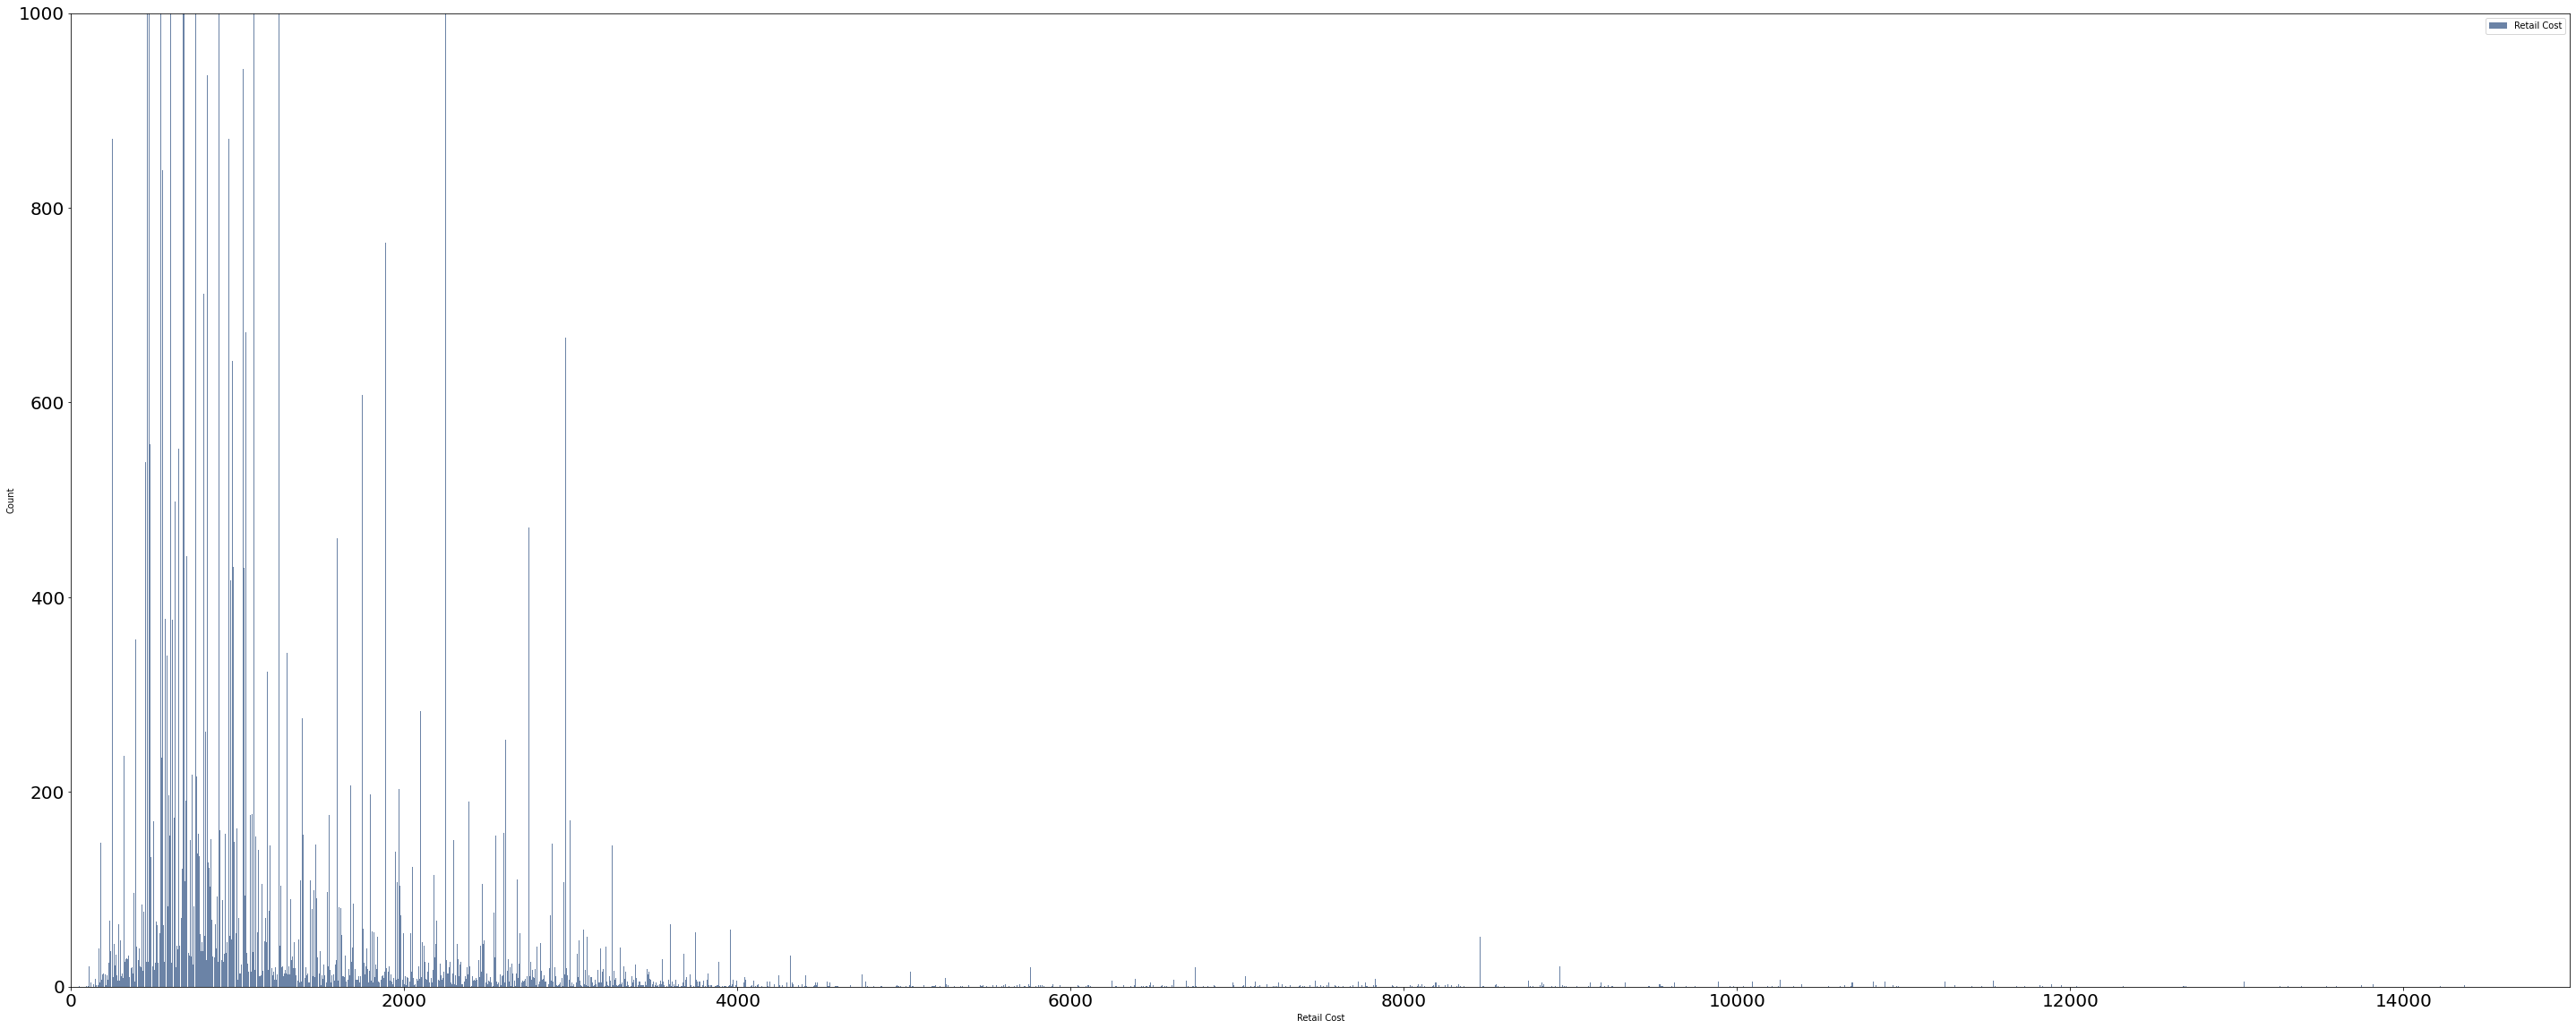

In [63]:
plt.figure(figsize=(50,20))
flr_retail = np.floor(df_variables['ProductRetailAmount'])
hist_prem = thinkstats2.Hist(flr_retail, label='Retail Cost')
thinkplot.Hist(hist_prem)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
thinkplot.Config(xlabel='Retail Cost', ylabel='Count', xlim=[0, 15000], ylim=[0, 1000])

The Product Retail Amount histogram above shows that most of the products sold retail below approx. 1,500 dollars but we also see a spike around 2,500 to 3,500. This could be speciality refriderators etc. The outliers in the retail costs are high end products, some, I found during EDA,  were input incorrectly into the system of record. 

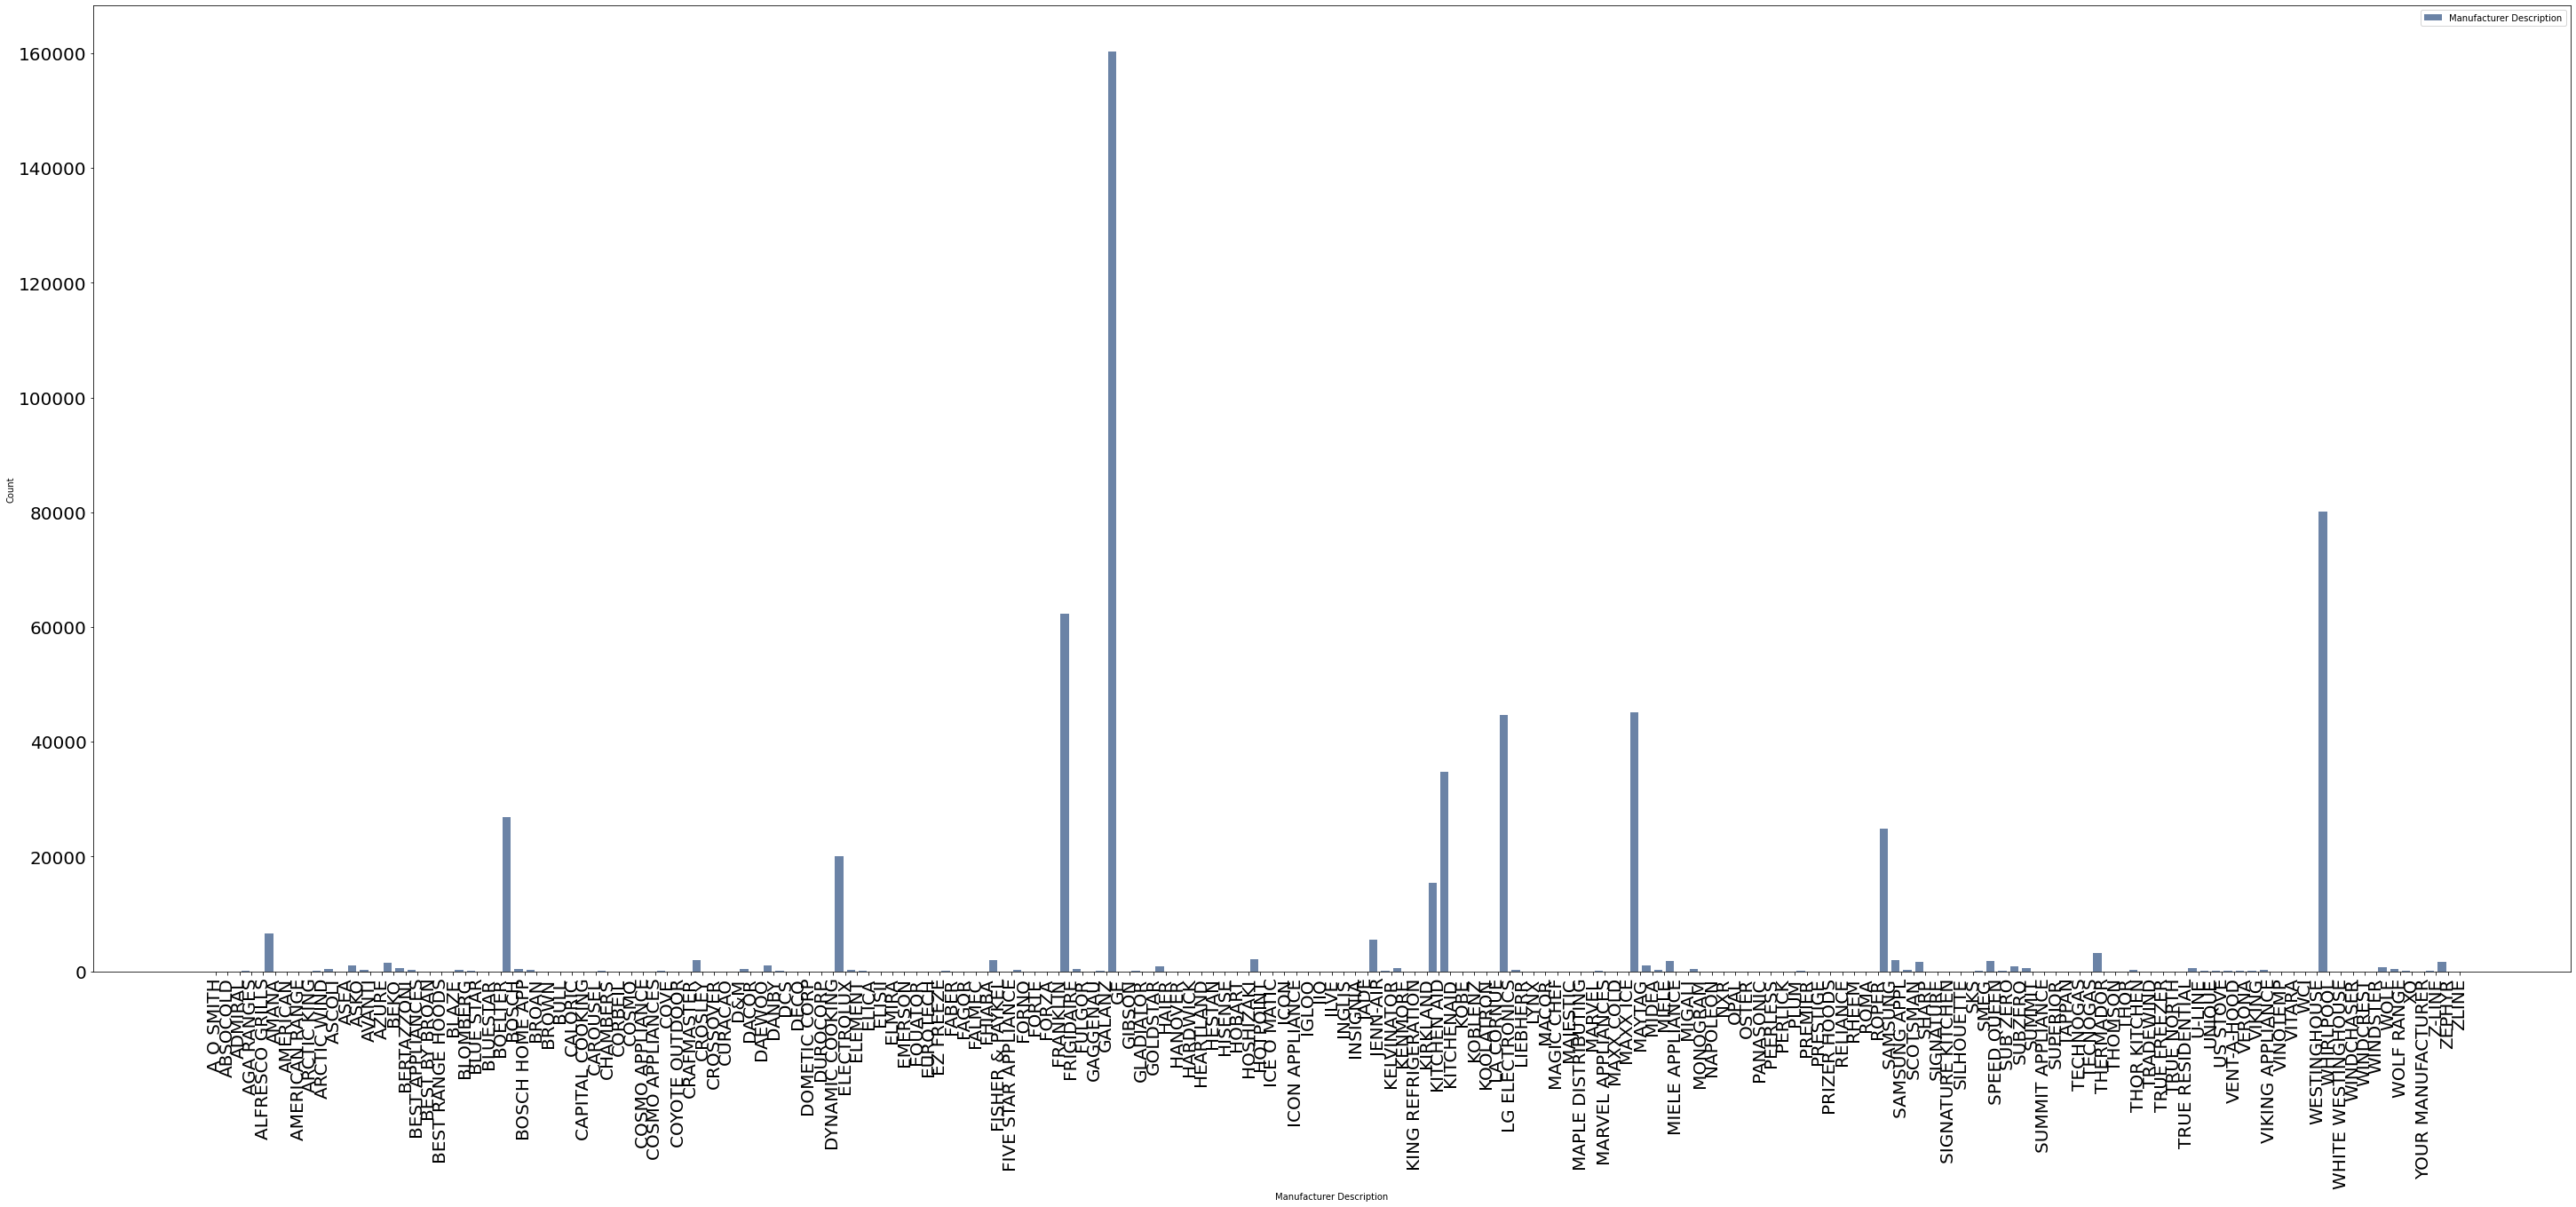

In [64]:
plt.figure(figsize=(50,20))
df3 = df_variables.sort_values(by=['ManufacturerDescription'], ascending=False)
histogram_manufacturer = thinkstats2.Hist(df3['ManufacturerDescription'], label='Manufacturer Description')
thinkplot.Hist(histogram_manufacturer, align='center', width=0.7)
plt.xticks(rotation=90)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
thinkplot.Config(xlabel='Manufacturer Description', ylabel='Count')

The histogram above shows the count of products by manufacturer.  We can see that GE outweighs the sales by far.  Outliers would be the brands with very low sells. 

The table below adds a column for a new variable, Current Loss Ratio. Which is the ratio of claims to premium over the period in question (past 3 years). There is also a ratio called "Ultimate Loss Ratio" which I will touch on later in the project. 

In [65]:
Calc_pivot = df.pivot_table(index =['ProductDescription'], 
                       values = ['ContractCostAmount', 'ClaimAmount'], 
                       aggfunc = 'sum')

Calc_pivot['CurrentLosssRatio'] = (Calc_pivot['ClaimAmount'] / Calc_pivot['ContractCostAmount']).round(4)


Calc_pivot

,ClaimAmount,ContractCostAmount,CurrentLosssRatio
ProductDescription,,,
CONVECTION OVEN,0.00,1.037010e+03,0.0000
COOKTOP,29802.87,6.592025e+05,0.0452
DISHWASHER,702077.16,4.660735e+06,0.1506
DOUBLE OVEN,7733.90,8.163108e+04,0.0947
DOUBLE OVEN RANGE,0.00,1.585000e+02,0.0000
DRYER,440861.14,3.945050e+06,0.1118
FREEZER,66478.68,1.146319e+06,0.0580
FURNACE,0.00,3.890290e+03,0.0000
GAS COOKTOP,194.80,6.204400e+03,0.0314


Summarizing by the Product Description and calculate current loss ratio.  Created new variable, Current Loss Ratio, which tells us the likelihood of a loss happening on a product:  Refrigerator = LR of 0.1915, loss will happen at least 19% of the time within the first 3 years of the gross written premium.  This will only increase with calculating on earned premium, which is the contract cost earned over the contract term.  Typically a factor of 4x. You want to see a gross loss ratio around .15 or lower.

Summarizing the claims and premium totals by year sold, shows there has been an increase year over year.  Per the claim data, most are incurred within years 2 and 3 of the contract term.

__Using Pg.29 of your text as an example, compare two scenarios in your data using PMF.__ 

In [66]:
df_variables_fridge = df_variables.loc[df_variables['ProductDescription'] == 'REFRIGERATOR']
df_variables_washer = df_variables.loc[df_variables['ProductDescription'] == 'WASHER']

In [67]:
fridge_pmf = thinkstats2.Pmf(df_variables_fridge['ContractCostAmount'], label='REFRIDGERATOR')
washer_pmf = thinkstats2.Pmf(df_variables_washer['ContractCostAmount'], label='WASHER')

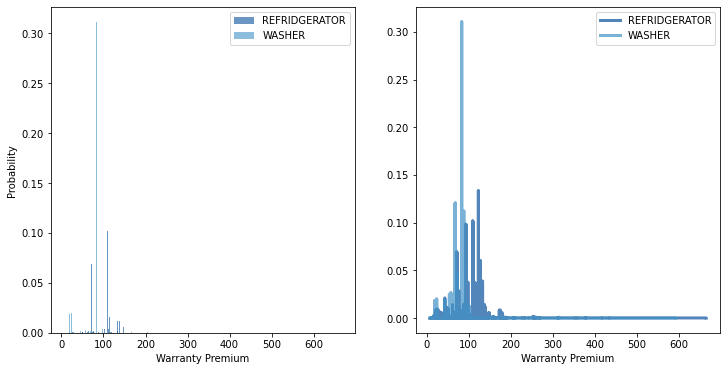

In [68]:
thinkplot.PrePlot(2, cols=2)
width = 0.45
thinkplot.Hist(fridge_pmf, align='right', width=width)
thinkplot.Hist(washer_pmf, align='right', width=width)
thinkplot.Config(xlabel='Warranty Premium', 
                 ylabel='Probability')

thinkplot.PrePlot(2)
thinkplot.SubPlot(2)
thinkplot.Pmfs([fridge_pmf, washer_pmf])
thinkplot.Config(xlabel='Warranty Premium')

__Create 1 CDF with one of your variables, using pages 41-44 as your guide.__

In [69]:
fridge_cdf = thinkstats2.Cdf(df_variables_fridge['ContractCostAmount'], label='REFRIDGERATOR')
washer_cdf = thinkstats2.Cdf(df_variables_washer['ContractCostAmount'], label='WASHER')

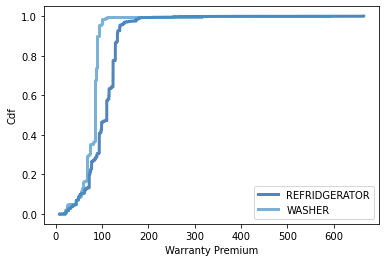

In [70]:
thinkplot.PrePlot(2)
thinkplot.Cdfs([fridge_cdf, washer_cdf])
thinkplot.Config(xlabel='Warranty Premium', ylabel='Cdf')

__Plot 1 analytical distribution and provide your analysis on how it applies to the dataset you have chosen.__

In [71]:
def MakeNormalModel(ProductCost):

    cdf = thinkstats2.Cdf(ProductCost, label='Product Cost')

    mean, var = thinkstats2.TrimmedMeanVar(ProductCost)
    std = np.sqrt(var)
    print('n, mean, std', len(ProductCost), mean, std)

    xmin = mean - 4 * std
    xmax = mean + 4 * std

    xs, ps = thinkstats2.RenderNormalCdf(mean, std, xmin, xmax)
    thinkplot.Plot(xs, ps, label='model', linewidth=4, color='0.8')
    thinkplot.Cdf(cdf)

In [72]:
df_costs = df_variables['ProductRetailAmount']

n, mean, std 561962 1218.6719245211762 805.0112852985548


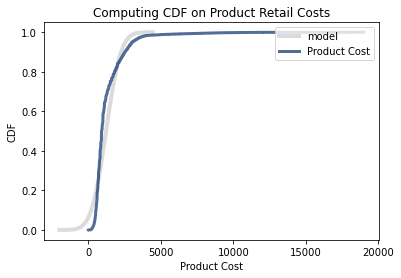

In [73]:
MakeNormalModel(df_costs)
thinkplot.Config(title='Computing CDF on Product Retail Costs', xlabel='Product Cost',
                 ylabel='CDF', loc='upper right')

From the plot above, the model seems to be a good fit.  

__Create two scatter plots comparing two variables and provide your analysis on correlation and causation.  Remeber, covariance, Pearson's correlation, and Non-Linear Relationships should be considered during your analysis.__

In [74]:
df_contract = df_variables['ContractCostAmount']
df_claim = df_variables['ClaimAmount']
df_retail = df_variables['ProductRetailAmount']

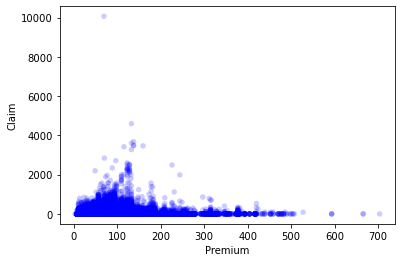

In [75]:
thinkplot.Scatter(df_contract, df_claim)
thinkplot.Config(xlabel='Premium', ylabel='Claim')

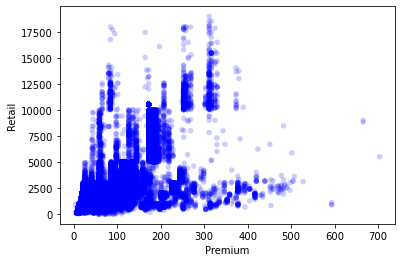

In [76]:
thinkplot.Scatter(df_contract, df_retail)
thinkplot.Config(xlabel='Premium', ylabel='Retail')

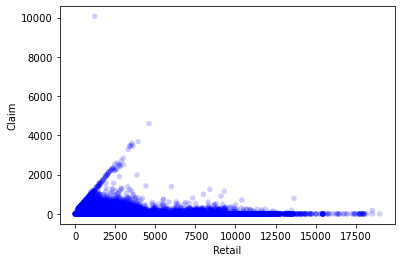

In [77]:
thinkplot.Scatter(df_retail, df_claim)
thinkplot.Config(xlabel='Retail', ylabel='Claim')

In [78]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

In [79]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

In [80]:
def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

Covariance, Correlation and Spearman Correlation when testing the cost of the warranty contract to claims on the product:

In [81]:
Cov(df_contract, df_claim)

149.30988418245076

With the positive covariance, there will be more claims as we sell more warranties, both variables will move in the same direction as they change. 

In [82]:
Corr(df_contract, df_claim)

0.07639866230030148

Since the correltaion is pretty low, it's showing that not all contracts will product a claim.  Which is positive thing.  To test further, you could run the correlations between each product to claims experience to find the product or even manufacturer with most potential to produce a claim. The look at the possibility of not covering that particular item.

In [83]:
SpearmanCorr(df_contract, df_claim)

0.09263744970197775

Again, shows the correlation is low when looking at the popualtion as a whole.   

Covariance, Correlation and Spearman Correlation when testing the cost of the warranty contract to retail price of the product:


In [84]:
Cov(df_contract, df_retail)

25962.373506807635

In [85]:
Corr(df_contract, df_retail)

0.7055280698915519

In [86]:
SpearmanCorr(df_contract, df_retail)

0.7333165225840887

Covariance, Correlation and Spearman Correlation when testing retail price of the product to claims:

In [87]:
Cov(df_retail, df_claim)

3054.644804140891

In [88]:
Corr(df_retail, df_claim)

0.048319763400857176

In [89]:
SpearmanCorr(df_retail, df_claim)

0.06733096051930627

__Conduct a test on your hypothesis using on the methonds covered in Chapter 9.__

In [90]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [91]:
df_claim_ = df_variables_fridge['ClaimAmount'].values, df_variables_washer['ClaimAmount'].values

In [92]:
ht = DiffMeansPermute(df_claim_)
pvalue = ht.PValue()
pvalue

0.0

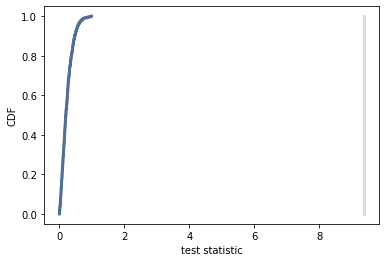

<Figure size 576x432 with 0 Axes>

In [93]:
ht.PlotCdf()
thinkplot.Show(xlabel = 'test statistic', ylabel = 'CDF')

__For this project, conduct a regression analysis on either one dependent and one explanatory variable, or multiple explanatory variables (Chapter 10 & 11).__

In [94]:
formula = 'df_variables["ContractCostAmount"] ~ df_variables["ClaimAmount"]'
model = smf.ols(formula, data=df_variables)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     df_variables["ContractCostAmount"]   R-squared:                       0.006
Model:                                            OLS   Adj. R-squared:                  0.006
Method:                                 Least Squares   F-statistic:                     3299.
Date:                                Sat, 19 Nov 2022   Prob (F-statistic):               0.00
Time:                                        00:15:35   Log-Likelihood:            -2.7729e+06
No. Observations:                              561962   AIC:                         5.546e+06
Df Residuals:                                  561960   BIC:                         5.546e+06
Df Model:                                           1                                         
Covariance Type:                            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      74.9796      0.046   1643.251      0.000      74.890      75.069
df_variables["ClaimAmount"]     0.0445      0.001     57.439      0.000       0.043       0.046
==============================================================================
Omnibus:                   216644.764   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2157554.731
Skew:                           1.577   Prob(JB):                         0.00
Kurtosis:                      12.066   Cond. No.                         59.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__Outcome of EDA__

The below questions will help address the main question of:  *How can we make dealers and products more profitable by determinig the relationships of the data points collected?* 

1. Can a predictive model help project claims assumptions using historical data and trends? 
2. Has there been in an increase in claims volume, or a decrease? 
3. Are there regional concentrations of dealers that are performing under contract terms? 
4. Can we pinpoint ill performing dealers with the model? 
5. Are the claims increasing or decreasing in a certain product group? 
6. Are the claims increasing or decreasing in relation to a certain product and manufacturer? 
7. Is there sufficient reserves for future claims? 
8. Are the warranty products priced correctly?

Within the warranty business, the process of claims is approaching real time acceptance and denial. The certificate to replace a product, service a product and pay any associated costs with the claim needs to happen within a set time frame according to contract terms. Usually within 72 hours. An example within this project case with appliances would be to determine if the product is serviceable, start the process to get a tech out to the house.  If determined to be a total loss, send certificate for full replacement and any associated costs with that replacement such as food loss. I began with EDA on my data sets, determining if I have sufficient volume with 3 years of sales and claims historical.  I then calculated the ultimate loss ratio to determine if the premiums outweigh the loss projections. With this information I then conducted a correlation exercise to determine what data point has the most impact on the ultimate loss ratio. These steps lead to the regression analysis on how the products will perform in the future and whether the business model is sustainable.

The earnings pattern of the warranties sold should more than cover the cost to service the product over the life of the warranty. My approach addressed many aspects of what determines to be a good profit margin (15% or greater) and an ultimate loss ratio of 73%.  I can not say it will be fully addressed as there may be factors outside of my approach that I can address in future project work. When complete, a recommendation can be given as to the areas that need to be addressed to improve the products performance within the pricing model, claims costs and cost sharing.

In [95]:
myTable = PrettyTable(["Product", "Net Adjusted Premium", "Paid claims", "Future Claim Liability",\
                       "Ulitmate Losses", "Ultimate Loss Ratio"])

myTable.add_row(["Refridgerators", "$13,027,882", "$1,025,254", "$11,777,503", "$12,802,756", "98.3%"])
myTable.add_row(["Washers", "$6,552,717", "$463,709", "$4,942,869", "$5,406,578", "82.5%"])
myTable.add_row(["Other Appliances", "$14,911,779", "$836,660", "$9,090,615", "$9,927,275", "66.7%"])
myTable.add_row(["Television", "$495,786", "$70,009", "$335,904", "$405,912", "81.9%"])
myTable.add_row(["TOTAL", "$34,988,163", "$2,395,632", "$26,146,890", "$28,542,521", "81.6%"])

print(myTable)

+------------------+----------------------+-------------+------------------------+-----------------+---------------------+
|     Product      | Net Adjusted Premium | Paid claims | Future Claim Liability | Ulitmate Losses | Ultimate Loss Ratio |
+------------------+----------------------+-------------+------------------------+-----------------+---------------------+
|  Refridgerators  |     $13,027,882      |  $1,025,254 |      $11,777,503       |   $12,802,756   |        98.3%        |
|     Washers      |      $6,552,717      |   $463,709  |       $4,942,869       |    $5,406,578   |        82.5%        |
| Other Appliances |     $14,911,779      |   $836,660  |       $9,090,615       |    $9,927,275   |        66.7%        |
|    Television    |       $495,786       |   $70,009   |        $335,904        |     $405,912    |        81.9%        |
|      TOTAL       |     $34,988,163      |  $2,395,632 |      $26,146,890       |   $28,542,521   |        81.6%        |
+---------------

We can see here from the summary table above that the Ultimate Loss Ratio is above the target 73% for the book of business. The formula = Ultimate Losses/Net Adjusted Premium = Ultimate Loss Ratio.

There are several further investigations to determine next steps but we can conclude:  

1. Refrigerators are number one in all categories:  total premium sold, total claims and loss ratio. Followed by washers, number 2 in sales and number 3 in loss ratio. These 2 products make up more than 50% of the top 15 product groups in terms of number sold, premium collected and losses incurred.   
2. Whirlpool and Frigidaire are the lowest performing manufacturers in these product groups.   
3. Bray & Scarff followed by Good Deals are lowest performing dealers in the top 15.   
4. Sales and claims concentration fall in 2 states, CA followed by FL.   
5. The product retail price correlates to the loss amount incurred, meaning the higher the price of the item, the higher the loss claim amount is. 

__What do you feel was missed during the analysis?__

From my EDA above, I was not able to address the reserving issues that could happen with future claim liabilites to the extent I would have liked.   For Future Discovery. 

__Were there any variables you felt could have helped in the analysis?__

There were a few limitations on how the overall operating income performance is scored.  The largest being, I did not have access to the overhead expenses on servicing these dealers and products.  Assumption is, as long as the Ultimate Loss Ratio remains at or below 73%, the company will be profitable. This is a big assumption as salaries and related is the second largest expense for this business model outside of losses. 

__Were there any assumptions made you feel were incorrect?__

The assumptions I presumed, the greater the value of the product the higher the claims will be, was verified.  However, I did expect a higher correlation between the product groups and claims.  

__What challenges did you face, what did you not fully understand?__

One of the challenges I faced during this project included cleaning the data set once it was quereied from an internal SQL Database.  I found that some free form data points were keyed incorrectly such as the product retail amount being $20,000 for a television etc.  Another challenge I faced that I did not fullly understand was my PValue coming out as 0.0.  From my understanding, a PValue of 0.0 says to reject my null hypothesis.  

After reviewing all the data and performing the analysis above, the buying group in question is performing below the contractual expectation.  The next steps will be to take a deeper dive into the lowest performing dealers and their product mix (large appliances seem to be the highest claims producers) to either drop coverage on certain manufacturers products or instill loss sharing within the contract per dealer.  Where if their ultimate loss ratio goes above a certain threshold, such as 73%, they will share the cost of those claims. As well as review the pricing models to ensure the warranty premium is adjusting with current inflation models. 
